In [1]:
import torch
import torch.nn as nn

In [2]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU())
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
    
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super().__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)
    
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x

In [4]:
class ResNet2(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super().__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU())  # 14x14
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # 7x7
        self.layer0 = self._make_layer(block, 64, layers[0], stride=1)  # 7x7
        self.layer1 = self._make_layer(block, 128, layers[1], stride=2)  # 4x4
        self.avgpool = nn.AvgPool2d(4, stride=1)  # 1x1
        self.fc = nn.Linear(128, num_classes)
    
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x

In [5]:
num_classes = 10
num_epochs = 10
batch_size = 256
lr = 0.1

model = ResNet2(ResidualBlock, [2, 3])

#Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)  

In [6]:
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_train = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
mnist_test = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

print(len(mnist_train), len(mnist_test))
print(mnist_test[0][0].shape)

60000 10000
torch.Size([1, 28, 28])


In [7]:
from torch.utils.data import DataLoader

train_loader = DataLoader(mnist_train, batch_size=256, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=256, shuffle=False)

In [8]:
import matplotlib.pyplot as plt

def train(num_epochs, net, optimizer):
    def run_epoch(net, dataloader, train):
        total_loss = 0
        if train:
            for inputs, labels in dataloader:
                optimizer.zero_grad()
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            return total_loss
        else:
            with torch.no_grad():
                for inputs, labels in dataloader:
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)
                    total_loss += loss.item()
                return total_loss
    
    loss_list = []
    for _ in range(num_epochs):
        run_epoch(net, train_loader, True)
        loss_list.append(run_epoch(net, test_loader, False))
    
    epochs = list(range(1, len(loss_list) + 1))
    plt.plot(epochs, loss_list, label='Train Loss', color='blue', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

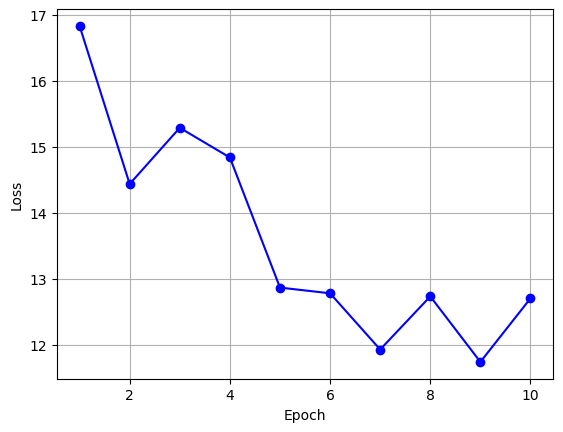

In [9]:
train(num_epochs, model, optimizer)